## Recommender system compare techniques
In this project content based recommendation and item based collaborating filtering techniques are explored and evaluated. For item based collaboration two models, one based on pearson correlation and the other based cosine distance are created and compared. 

The graphlab package is used to build the recommendation models.

In [1]:
%%capture
import logging
logging.getLogger().setLevel(logging.ERROR)
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import graphlab as gl
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (14,10)

### Data
The dataset used in this system contains the number of time a user listened music from a particular artist.  The dataset contains 92834 relations between 1892 users and 17632 artists. 

Data source: https://grouplens.org/datasets/hetrec-2011/ (Last.FM)

The dataset provides the number of times a user listened to a particular artist. This information is used as implicit rating (i.e more the number of times a user listened to an artist then better the rating of the artist for that user).  

The dataset contains tags(music genres) for the artists as well. The tags provide information about the artist and so they represent the item features. These tags are used for content based recommendation. 

In [2]:
#Read dataset using panda
artists = pd.read_csv("../data/artists.dat",sep="\t")
listen_count = pd.read_csv("../data/user_artists.dat",sep="\t")
artists_tag= pd.read_csv("../data/user_taggedartists.dat", sep="\t")

In [3]:
artists.head()

,id,name,url,pictureURL
0,1,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg
2,3,Carpathian Forest,http://www.last.fm/music/Carpathian+Forest,http://userserve-ak.last.fm/serve/252/40222717...
3,4,Moi dix Mois,http://www.last.fm/music/Moi+dix+Mois,http://userserve-ak.last.fm/serve/252/54697835...
4,5,Bella Morte,http://www.last.fm/music/Bella+Morte,http://userserve-ak.last.fm/serve/252/14789013...


In [4]:
listen_count.head()

,userID,artistID,weight
0,2,51,13883
1,2,52,11690
2,2,53,11351
3,2,54,10300
4,2,55,8983


In [5]:
artists_tag.head()

,userID,artistID,tagID,day,month,year
0,2,52,13,1,4,2009
1,2,52,15,1,4,2009
2,2,52,18,1,4,2009
3,2,52,21,1,4,2009
4,2,52,41,1,4,2009


### Data Transformation

Both recommendation and tag information are provided in long format. Let's convert it to wide format in order to perform dimension reduction. Let's also center and scale the data in order to get normalized values.


In [6]:
#Long to wide
rating=listen_count.pivot_table(index="userID",columns="artistID",values="weight")

### Dimension Reduction
The dataset provided is large and sparse. In order to build the recommendation engine without incurring too much of computing cost the data dimension needs to be reduced. For this project top 1000 artists only considered. For content based method top 200 tags of the artists are only considered (Various values for the number of tags are tried and 200 found to be optimal value which provides decent predictions). 

In [7]:
top_rat=rating.iloc[:,np.argsort(-rating.sum(axis=0))].iloc[:,0:1000]
top_rat=top_rat.sub(top_rat.mean(axis=1),axis=0).div(top_rat.std(axis=1),axis=0)
top_rat.head()

artistID,289,72,89,292,498,67,288,701,227,300,...,1879,1994,2554,15347,1747,4487,891,514,2309,3729
userID,,,,,,,,,,,,,,,,,,,,,
2,NaN,-0.401056,-0.727835,NaN,NaN,-0.198453,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,5.558606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.676464,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
#Pick users who have listened to at least 10 artists
top_rat=top_rat[top_rat.count(axis=1)>5]
top_rat.shape

(1813, 1000)

In [9]:
top_rat_long=top_rat.stack().reset_index()
top_rat_long.columns=["userID","artistID","rating"]
top_rat_long.head()

,userID,artistID,rating
0,2,72,-0.401056
1,2,89,-0.727835
2,2,67,-0.198453
3,2,55,1.489509
4,2,51,2.945161


### Prepare test and train data
Graphlab data split utility function is used to split the data into train and test set.

In [10]:
rating_sf=gl.SFrame(top_rat_long)
train_sf, test_sf = gl.recommender.util.random_split_by_user(rating_sf,user_id='userID', item_id='artistID',
                                            max_num_users=200, item_test_proportion=0.8,
                                                random_seed=0)

This non-commercial license of GraphLab Create for academic use is assigned to mohan.kandaraj@spsmail.cuny.edu and will expire on August 30, 2017.


## Content Based Recommendation

### Build features
Use tags to create item (artist) features. 

In [11]:
artists_features = artists_tag.pivot_table(index="artistID",columns="tagID", 
                                           values="userID",aggfunc='count')
artists_features=artists_features[artists_features.index.isin(top_rat.columns.values)]
artists_features=artists_features.iloc[:,np.argsort(-artists_features.sum(axis=0))].iloc[:,0:200]
artists_features.shape

(995, 200)

Replace missing values with zero as a missing value means that the artist is not tagged with that music genre. Center and Scale values in order to get normalized values.

In [12]:
artists_features=artists_features.fillna(0)
artists_features.head()

tagID,73,24,79,81,130,18,78,39,25,192,...,1355,2752,98,347,689,1237,8303,1495,738,5818
artistID,,,,,,,,,,,,,,,,,,,,,
7,18.0,0.0,9.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
artists_features=artists_features.sub(artists_features.mean(axis=1),axis=0).\
    div(artists_features.std(axis=1),axis=0)
artists_features.head()

tagID,73,24,79,81,130,18,78,39,25,192,...,1355,2752,98,347,689,1237,8303,1495,738,5818
artistID,,,,,,,,,,,,,,,,,,,,,
7,5.792005,-0.222191,2.784907,-0.222191,-0.222191,-0.222191,0.446053,-0.222191,-0.222191,-0.222191,...,-0.222191,-0.222191,-0.222191,-0.222191,-0.222191,-0.222191,-0.222191,-0.222191,-0.222191,-0.222191
8,2.612341,-0.123095,-0.123095,-0.123095,-0.123095,-0.123095,-0.123095,-0.123095,-0.123095,-0.123095,...,-0.123095,-0.123095,-0.123095,-0.123095,-0.123095,-0.123095,-0.123095,-0.123095,-0.123095,-0.123095
9,-0.130170,-0.130170,-0.130170,-0.130170,-0.130170,0.954579,-0.130170,-0.130170,-0.130170,-0.130170,...,-0.130170,-0.130170,-0.130170,-0.130170,-0.130170,-0.130170,-0.130170,-0.130170,-0.130170,-0.130170
12,-0.070711,-0.070711,-0.070711,-0.070711,-0.070711,-0.070711,-0.070711,-0.070711,-0.070711,-0.070711,...,-0.070711,-0.070711,-0.070711,-0.070711,-0.070711,-0.070711,-0.070711,-0.070711,-0.070711,-0.070711
25,-0.140720,-0.140720,-0.140720,-0.140720,-0.140720,-0.140720,-0.140720,-0.140720,-0.140720,-0.140720,...,-0.140720,-0.140720,-0.140720,-0.140720,-0.140720,-0.140720,-0.140720,-0.140720,-0.140720,-0.140720


### Build Content Based Recommendation Model

In [14]:
%%capture
artists_feat=gl.SFrame(artists_features.reset_index())
content_model=gl.recommender.item_content_recommender.create(artists_feat, "artistID")

In [15]:
#Function to make predictions
def content_predict(ratings,content_model):
    reco_all = pd.DataFrame()
    for index, items_rating in ratings.iterrows():
        items_viewed=items_rating.index[items_rating>1].values.tolist()
        #print items_viewed
        reco=content_model.recommend_from_interactions(items_viewed[1:]).to_dataframe()
        reco.insert(0,"userID", items_rating[0])
        reco_all=pd.concat([reco_all,reco])
    return reco_all

### Make Predictions

In [16]:
#Get test user
test_user=test_sf["userID"].to_numpy()
test_content=top_rat[top_rat.index.isin(test_user)]

In [17]:
#Make prediction
content_reco=content_predict(test_content.reset_index(),content_model)
content_reco["userID"]=content_reco.userID.astype(int)
content_reco_sf=gl.SFrame(content_reco)

### Evaluate Model
In order to evaluate the model let's check the precision.

In [18]:
test_rating=top_rat_long[top_rat_long.userID.isin(test_user)]
test_rating_sf=gl.SFrame(test_rating)

In [19]:
cont_pr_rec=gl.recommender.util.precision_recall_by_user(test_rating_sf,content_reco_sf)
cont_pr_rec.print_rows(10)
cont_pr_rec_df=cont_pr_rec.to_dataframe()

+--------+--------+-----------+----------------+-------+
| userID | cutoff | precision |     recall     | count |
+--------+--------+-----------+----------------+-------+
|   6    |   10   |    0.0    |      0.0       |   18  |
|   7    |   10   |    0.0    |      0.0       |   46  |
|   8    |   10   |    0.0    |      0.0       |   30  |
|   15   |   10   |    0.0    |      0.0       |   32  |
|   25   |   10   |    0.0    |      0.0       |   42  |
|   32   |   10   |    0.0    |      0.0       |   38  |
|   41   |   10   |    0.0    |      0.0       |   21  |
|   43   |   10   |    0.0    |      0.0       |   40  |
|   50   |   10   |    0.0    |      0.0       |   44  |
|   59   |   10   |    0.1    | 0.027027027027 |   37  |
+--------+--------+-----------+----------------+-------+
[200 rows x 5 columns]



In [20]:
## Check overall Precision
cont_pr_rec_df.precision.mean()

0.024000000000000004

The content based collaboration model gives average precision of about 2.4% which is not great. But still it's better than a random guess on 1000 items (which would have expected precision of .1%).

## Item based collaborative filtering model

#### Using Pearson Correlation as similarity measure

In [21]:
%%capture
#Build IBCF model using graphlab
ibcm=gl.item_similarity_recommender.create(train_sf, user_id="userID",
                                           item_id="artistID",target="rating",
                                           similarity_type='pearson',only_top_k=15
                                              )

In [22]:
#Make prediction
ibcm.predict(test_sf)
ibcm_reco=ibcm.recommend()

recommendations finished on 1000/1807 queries. users per second: 211282

In [23]:
#Preview prediction
ibcm_reco.head()

userID,artistID,score,rank
2,15075,3.14399492966,1
2,6373,3.12452051379,2
2,2301,2.4305600818,3
2,4625,2.02472102619,4
2,8308,2.00071332775,5
2,13182,1.90745348946,6
2,9363,1.90703596616,7
2,1933,1.89725549759,8
2,14185,1.82662933062,9
2,6150,1.63947664696,10


In [24]:
ib_pr_rec=gl.recommender.util.precision_recall_by_user(test_rating_sf,ibcm_reco)
ib_pr_rec.head()

userID,cutoff,precision,recall,count
6,10,0.0,0.0,18
7,10,0.0,0.0,46
8,10,0.0,0.0,30
15,10,0.0,0.0,32
25,10,0.0,0.0,42
32,10,0.0,0.0,38
41,10,0.0,0.0,21
43,10,0.0,0.0,40
50,10,0.0,0.0,44
59,10,0.0,0.0,37


In [25]:
ib_pr_rec_df=ib_pr_rec.to_dataframe()
ib_pr_rec_df.precision.mean()

0.0005

The item based collaboration model didn't perform well when pearson correlation is used. Let's try the model with cosine distance.  

#### Using cosine distance
The item based model using pearson correlation didn't perform well. Let's try a model using cosine distance

In [26]:
%%capture
#Build IBCF model using graphlab - using cosine similarity
ibcm=gl.item_similarity_recommender.create(train_sf, user_id="userID",
                                           item_id="artistID",target="rating",
                                           similarity_type='cosine',only_top_k=15)
#Make prediction
ibcm.predict(test_sf)
ibcm_reco=ibcm.recommend()

In [27]:
ib_pr_rec=gl.recommender.util.precision_recall_by_user(test_rating_sf,ibcm_reco)
ib_pr_rec.head()

userID,cutoff,precision,recall,count
6,10,0.0,0.0,18
7,10,0.5,0.108695652174,46
8,10,0.1,0.0333333333333,30
15,10,0.1,0.03125,32
25,10,0.1,0.0238095238095,42
32,10,0.2,0.0526315789474,38
41,10,0.1,0.047619047619,21
43,10,0.4,0.1,40
50,10,0.2,0.0454545454545,44
59,10,0.1,0.027027027027,37


In [28]:
ib_pr_rec_df=ib_pr_rec.to_dataframe()
ib_pr_rec_df.precision.mean()

0.1415000000000001

**The precision of the item based collaboratin model using cosine distance is about 14% which is a decent rate for a recommendation model.**

#### Model performance Vs number of rating
Let's check how the model performs given the rating data. 

We expect the performance of the content based model not to be affected by number of rating.

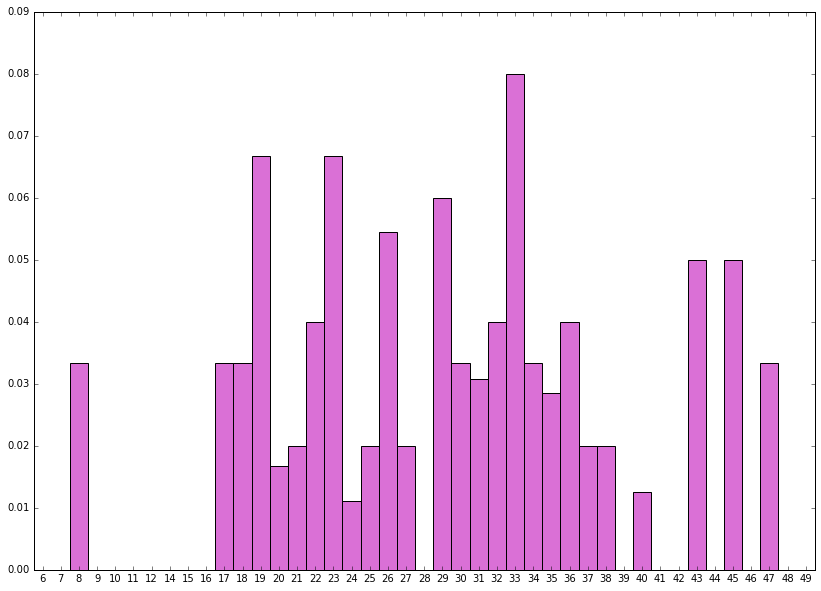

In [29]:
prec_by_count=cont_pr_rec_df[["count","precision"]].groupby("count").mean()
pos = np.arange(len(prec_by_count))
width = 1.0    
ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(prec_by_count.index.values)
plt.bar(pos,prec_by_count.precision , width, color='orchid')
plt.show()

As expected the performance of content based model appears to be not dependent on the number of available user rating. But overall it under performs item based collaborative model.

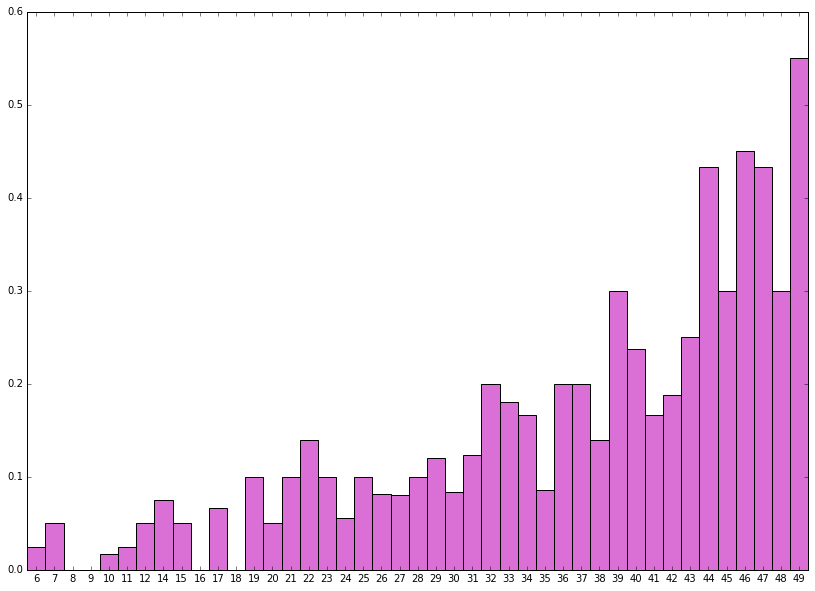

In [30]:
prec_by_count=ib_pr_rec_df[["count","precision"]].groupby("count").mean()
pos = np.arange(len(prec_by_count))
width = 1.0    
ax = plt.axes()
ax.set_xticks(pos + (width / 2))
ax.set_xticklabels(prec_by_count.index.values)
plt.bar(pos,prec_by_count.precision , width, color='orchid')
plt.show()

The item based collaboration model gets better as the number of available user rating increases.

### Conclusion
For the data analyzed the item based collaboration filtering method based on cosine distance performed better than content based recommendation method. The content based filtering method also required more computing resources to train (at least while using graphlab as pairwise distance was computed). The item based collaboration filtering method requires some amount of prior user rating and the performance of the model is correlated with number of ratings available. While the item based model using cosine distance performed well, the same model did worse than content based model if pearson correlation is used. 
